# **Project Code**

## Import frameworks

In [2]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from keras import optimizers, regularizers
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.callbacks import EarlyStopping
from keras.layers import MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.optimizers import SGD, Adamax
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

## Import data from kaggle

In [3]:
! pip install -q kaggle

In [4]:
# upload a Kaggle API key
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jamileh","key":"113f365ed2b049d4493985a5af10aab9"}'}

In [5]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d 'gpiosenka/100-bird-species/'

100% 1.95G/1.96G [02:13<00:00, 14.4MB/s]
100% 1.96G/1.96G [02:13<00:00, 15.7MB/s]


In [10]:
! unzip "/content/100-bird-species.zip" -d birds

Streaming output truncated to the last 5000 lines.
  inflating: birds/train/WHITE TAILED TROPIC/120.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/121.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/122.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/123.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/124.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/125.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/126.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/127.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/128.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/129.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/130.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/131.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/132.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/133.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/134.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/135.jpg  
  inflating: birds/train/WHITE TAILED TROPIC/136.jpg  
  inflating: b

## EDA

In [11]:
birdTypes = os.listdir('/content/birds/train')
len(birdTypes)

525

In [12]:
# Get paths to train data and validation data
train_data_dir = pathlib.Path('/content/birds/train')
validation_data_dir = pathlib.Path('/content/birds/valid')
test_data_dir = pathlib.Path('/content/birds/test')

In [13]:
# Create training data generator
train_data = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = train_data.flow_from_directory(train_data_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                class_mode='categorical')

# Create validation data generator
validation_data = ImageDataGenerator(preprocessing_function = preprocess_input)
validation_generator = validation_data.flow_from_directory(validation_data_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                class_mode='categorical')

# Create test data generator
test_data = ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_data.flow_from_directory(test_data_dir,
                                                batch_size=64,
                                                target_size=(224,224),
                                                class_mode='categorical')

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [14]:
# Get class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names[:20])

['ABBOTTS BABBLER', 'ABBOTTS BOOBY', 'ABYSSINIAN GROUND HORNBILL', 'AFRICAN CROWNED CRANE', 'AFRICAN EMERALD CUCKOO', 'AFRICAN FIREFINCH', 'AFRICAN OYSTER CATCHER', 'AFRICAN PIED HORNBILL', 'AFRICAN PYGMY GOOSE', 'ALBATROSS', 'ALBERTS TOWHEE', 'ALEXANDRINE PARAKEET', 'ALPINE CHOUGH', 'ALTAMIRA YELLOWTHROAT', 'AMERICAN AVOCET', 'AMERICAN BITTERN', 'AMERICAN COOT', 'AMERICAN DIPPER', 'AMERICAN FLAMINGO', 'AMERICAN GOLDFINCH']


In [15]:
# Get glob of all train images
train_img_list = list(train_data_dir.glob('*/*'))

In [16]:
# Open all train images
img_list = [PIL.Image.open(str(train_img_list[i])) for i in range(len(train_img_list))]

In [17]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_data_dir,
    batch_size=64,
    image_size=(224, 224),
    labels='inferred',
    label_mode='categorical',
    seed=42,
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory=validation_data_dir,
    batch_size=64,
    image_size=(224, 224),
    labels='inferred',
    label_mode='categorical',
    seed=42,
)

Found 84635 files belonging to 525 classes.
Found 2625 files belonging to 525 classes.


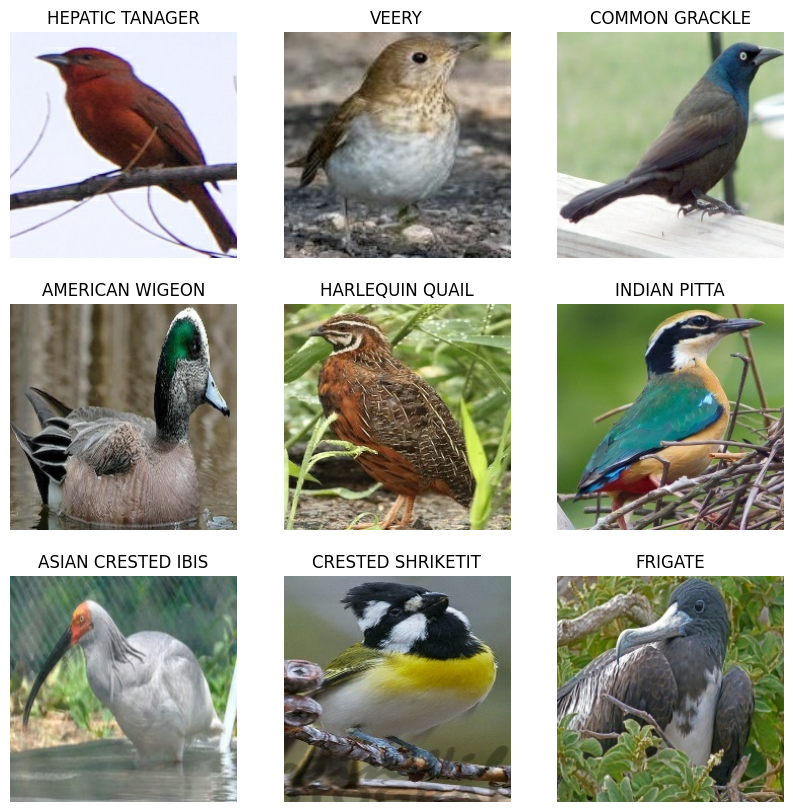

In [18]:
# Plot 9 sample images
plt.figure(figsize=(10, 10))

for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i], axis=None, out=None)])
    plt.axis("off")

## Model 1: VGG16

In [ ]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

vgg_model.trainable = False

layer0 = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
layer1 = tf.keras.layers.Dense(4096, activation='relu',name='fc1')(layer0)
layer2 = tf.keras.layers.Dense(4096, activation='relu',name='fc2')(layer1)
layer3 = tf.keras.layers.Dropout(0.5)(layer2)
out_layer = tf.keras.layers.Dense(525, activation='softmax')(layer3)
vgg_model = tf.keras.Model(vgg_model.input, out_layer)

optimizer = tf.keras.optimizers.AdamW(
  learning_rate=0.0001,
  weight_decay=1e-6
)

vgg_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]

In [ ]:
history = vgg_model.fit(train_generator, epochs=15, validation_data = validation_generator)

Epoch 1/15
1323/1323 [==============================] - 186s 139ms/step - loss: 5.3029 - accuracy: 0.2437 - val_loss: 1.4742 - val_accuracy: 0.6472
Epoch 2/15
1323/1323 [==============================] - 192s 145ms/step - loss: 2.1608 - accuracy: 0.5648 - val_loss: 1.0059 - val_accuracy: 0.7535
Epoch 3/15
1323/1323 [==============================] - 190s 144ms/step - loss: 1.6035 - accuracy: 0.6780 - val_loss: 0.8523 - val_accuracy: 0.7985
Epoch 4/15
1323/1323 [==============================] - 194s 146ms/step - loss: 1.2122 - accuracy: 0.7491 - val_loss: 0.6986 - val_accuracy: 0.8335
Epoch 5/15
1323/1323 [==============================] - 191s 145ms/step - loss: 0.9630 - accuracy: 0.7972 - val_loss: 0.6307 - val_accuracy: 0.8442
Epoch 6/15
1323/1323 [==============================] - 197s 149ms/step - loss: 0.8029 - accuracy: 0.8298 - val_loss: 0.6248 - val_accuracy: 0.8450
Epoch 7/15
1323/1323 [==============================] - 183s 138ms/step - loss: 0.7000 - accuracy: 0.8513 - val_

In [17]:
# Draw Learning curve
def learning_curve(hist):
  plt.subplot(2,1,1)
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')

  plt.subplot(2,1,2)
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')

  plt.show()

learning_curve(history)

NameError: ignored

In [ ]:
vgg_model.evaluate(test_generator,use_multiprocessing=True,workers=10)

42/42 [==============================] - 8s 156ms/step - loss: 0.3934 - accuracy: 0.9082


[0.39341336488723755, 0.9081904888153076]

## Model 2: Efficientnet


In [ ]:
# Defines number of classes in dense layer
class_count = len(list(train_generator.class_indices.keys()))

# Create pre-trained model on efficientnet
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(224,224,3), pooling='max')
# base_model.trainable = False
efficientnet_model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

efficientnet_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

efficientnet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization_4 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 525)               134925    
                                                                 
Total params: 4517552 (17.23 MB)
Trainable params: 447

In [ ]:
efficientnet_history = efficientnet_model.fit(x=train_generator, epochs=10, verbose=1,
                                              validation_data=validation_generator,
                                              validation_steps= None, shuffle= False)

Epoch 1/10
2645/2645 [==============================] - 325s 110ms/step - loss: 5.2799 - accuracy: 0.4588 - val_loss: 2.1675 - val_accuracy: 0.8998
Epoch 2/10
2645/2645 [==============================] - 288s 109ms/step - loss: 2.2100 - accuracy: 0.8424 - val_loss: 1.4650 - val_accuracy: 0.9436
Epoch 3/10
2645/2645 [==============================] - 287s 109ms/step - loss: 1.5770 - accuracy: 0.9098 - val_loss: 1.1666 - val_accuracy: 0.9600
Epoch 4/10
2645/2645 [==============================] - 288s 109ms/step - loss: 1.2522 - accuracy: 0.9390 - val_loss: 0.9897 - val_accuracy: 0.9672
Epoch 5/10
2645/2645 [==============================] - 290s 110ms/step - loss: 1.0479 - accuracy: 0.9561 - val_loss: 0.8741 - val_accuracy: 0.9684
Epoch 6/10
2645/2645 [==============================] - 288s 109ms/step - loss: 0.9003 - accuracy: 0.9668 - val_loss: 0.7935 - val_accuracy: 0.9695
Epoch 7/10
2645/2645 [==============================] - 287s 109ms/step - loss: 0.7915 - accuracy: 0.9737 - val_

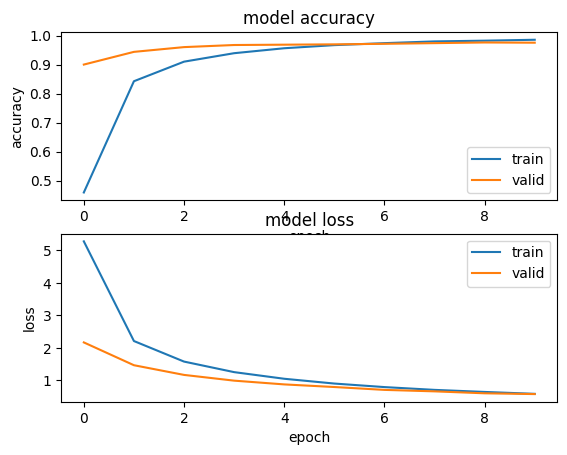

In [ ]:
learning_curve(efficientnet_history)

In [ ]:
efficientnet_model.evaluate(test_generator, use_multiprocessing=True, workers=10)

83/83 [==============================] - 6s 55ms/step - loss: 0.5114 - accuracy: 0.9893


[0.5114229917526245, 0.9893333315849304]

# AlexNet model architecture

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [27]:
train_dir = 'birds/train'
validation_dir = 'birds/valid'
test_dir = 'birds/test'

In [20]:
# AlexNet model expects 224x224 input images
batch_size = 64
image_size = (227, 227)  # AlexNet uses an image size of 227x227
num_classes = 525

In [21]:
# Define the AlexNet model architecture
def alexnet_model(num_classes):
    model = Sequential([
        Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(image_size[0], image_size[1], 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(256, (5, 5), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(384, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3, 3), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

In [22]:
# Initialize the model
model = alexnet_model(num_classes)

In [23]:
# Compile the model
# model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [24]:
# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [25]:
# Load the datasets using ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)


In [28]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


In [29]:
# Get number of classes from the training dataset
num_classes = len(train_generator.class_indices)

In [30]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,  # Set the number of epochs as per your requirement
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


Epoch 1/10
1322/1322 [==============================] - 256s 182ms/step - loss: 6.5170 - accuracy: 0.0028 - val_loss: 6.2647 - val_accuracy: 0.0019
Epoch 2/10
1322/1322 [==============================] - 234s 177ms/step - loss: 6.2987 - accuracy: 0.0029 - val_loss: 6.2939 - val_accuracy: 0.0019
Epoch 3/10
1322/1322 [==============================] - 228s 172ms/step - loss: 6.2611 - accuracy: 0.0031 - val_loss: 6.2677 - val_accuracy: 0.0019
Epoch 4/10
1322/1322 [==============================] - 228s 172ms/step - loss: 6.2582 - accuracy: 0.0031 - val_loss: 6.2688 - val_accuracy: 0.0019
Epoch 5/10
1322/1322 [==============================] - 226s 171ms/step - loss: 6.2614 - accuracy: 0.0031 - val_loss: 6.2696 - val_accuracy: 0.0019
Epoch 6/10
1322/1322 [==============================] - 223s 169ms/step - loss: 6.2600 - accuracy: 0.0031 - val_loss: 6.2701 - val_accuracy: 0.0019
Epoch 7/10
1322/1322 [==============================] - 229s 173ms/step - loss: 6.2598 - accuracy: 0.0031 - val_

In [31]:
# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2625 images belonging to 525 classes.


In [32]:
# Calculate the test accuracy and loss
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

41/41 [==============================] - 7s 165ms/step - loss: 6.2710 - accuracy: 0.0019
Test Loss: 6.27100944519043, Test Accuracy: 0.0019054878503084183


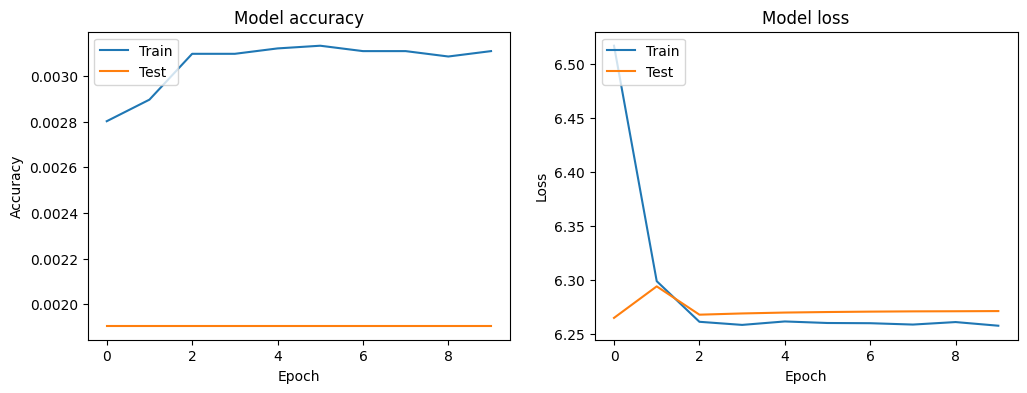

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()